## **Import statements and set random seed**

In [1]:
# import time
import time
t1 = time.time()

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 88
tf_rand_seed = 33
np.random.seed(np_rand_seed)
# print("random seed of numpy: ", np_rand_seed)
# print("random seed of tensorflow: ", tf_rand_seed)

# **Loading training data**

In [4]:
train_data = pd.read_csv('../input/train.csv')

In [5]:
train_data.shape

(42000, 785)

In [6]:
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
features = train_data.columns.tolist()
output = "label"
features.remove(output)

In [8]:
train_X = train_data[features].as_matrix()
train_X = train_X.reshape((-1, 28,28,1))

In [9]:
train_y = train_data[output].as_matrix()
train_y = train_y.astype(int)
train_y = pd.get_dummies(train_y).as_matrix()

In [10]:
train_X.shape

(42000, 28, 28, 1)

In [11]:
train_y.shape

(42000, 10)

# **Creating Convolutional Neural Network**

In [12]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
# sess = tf.InteractiveSession()

In [13]:
# image dimensions
width = 28
height = 28
num_channels = 1
flat = width * height
num_classes = 10

In [14]:
x_image = tf.placeholder(tf.float32, shape=[None,height, width, num_channels])
labels = tf.placeholder(tf.int32, shape=[None, num_classes])
keep_prob = tf.placeholder(tf.float32)

## **Create functions for creating deep learning layers¶**

In [15]:
def create_weights(shape):
    '''a function to create weight tensor'''
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    '''a function to create bias tensor'''
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [16]:
def create_convolutional_layer(input,
                               num_input_channels,
                               conv_filter_size,
                               max_pool_filter_size,
                               num_filters):  
    
    '''a function to create convoutional layer'''
    
    # create filter for the convolutional layer
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    # create biases
    biases = create_biases(num_filters)
    
    # create covolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    
    # add the bias to the convolutional layer
    layer += biases
    
    # relu activation layer fed into layer
    layer = tf.nn.relu(layer)
    
    # max pooling to half the size of the image
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, max_pool_filter_size, max_pool_filter_size, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
        
    # return the output layer of the convolution
    return layer

In [17]:
def create_flatten_layer(layer):
    
    '''a function for creating flattened layer from convolutional output'''
    
    # extract the shape of the layer
    layer_shape = layer.get_shape()
    # calculate the number features of the flattened layer
    num_features = layer_shape[1:4].num_elements()
    # create the flattened layer
    layer = tf.reshape(layer, [-1, num_features])
    # return the layer
    return layer

In [18]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=True,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    # matrix multiplication between input and weight matrix
    layer = tf.matmul(input, weights) + biases
    
    # add relu activation if wanted
    if use_relu:
        layer = tf.nn.relu(layer)
        
    # if dropout is wanted add dropout
    if dropout:        
        layer = tf.nn.dropout(layer, keep_prob)
    
    # return layer
    return layer

## **Create Layers of Covnet**

In [19]:
conv1_features = 64
conv1_filter_size = 5
max_pool_size1 = 2

conv2_features = 128
conv2_filter_size = 5
max_pool_size2 = 2

fc_layer_size1 = 1024
fc_layer_size2 = 512

In [20]:
layer_conv1 = create_convolutional_layer(input=x_image,
                                         num_input_channels= num_channels,
                                         conv_filter_size = conv1_filter_size,
                                         max_pool_filter_size = max_pool_size1,
                                         num_filters = conv1_features)
layer_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

In [21]:
layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels= conv1_features,
                                         conv_filter_size = conv2_filter_size,
                                         max_pool_filter_size = max_pool_size2,
                                         num_filters = conv2_features)
layer_conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 128) dtype=float32>

In [22]:
layer_flat = create_flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 6272) dtype=float32>

In [23]:
layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout=False)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

In [24]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=fc_layer_size2,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc2

<tf.Tensor 'dropout/mul:0' shape=(?, 512) dtype=float32>

In [25]:
output_layer = create_fc_layer(input=layer_fc2,
                     num_inputs = fc_layer_size2,
                     num_outputs = num_classes,
                     use_relu=False)
output_layer

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

## **Create prediction & accuracy metric**

In [26]:
y_pred = tf.nn.softmax(output_layer)
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)
y_true_cls = tf.argmax(labels, axis=1, output_type=tf.int32)

In [27]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## **Create Optimizers**

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer,
                                                    labels=labels)
loss = tf.reduce_mean(cross_entropy)

In [29]:
learning_rate = 1e-4
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# **Train Model**

In [30]:
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))

image_train = train_X[train_indices]
image_validation = train_X[validation_indices]

labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

In [31]:
train_loss = []
valid_loss = []
valid_acc = []

train_batch_size = 250
max_iter = 1400

In [32]:
iteration = 0
best_accuracy = 0
best_iteration = 0
saver = tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    # while 59 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 58*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        rand_index_train = np.random.choice(labels_train.shape[0], size=train_batch_size)
        image_rand_train = image_train[rand_index_train]    
        labels_rand_train = labels_train[rand_index_train]

        feed_dict_batch =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 0.7}
        
        feed_dict_train =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 1.0}

        feed_dict_validation =  {x_image: image_validation,
                                 labels: labels_validation,
                                 keep_prob:1.0}

        sess.run(train_step, feed_dict=feed_dict_batch)

        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)

        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)

        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)   
        
        # if valid accuracy is better than best recorded so far then update the best valid accuracy
        if temp_validation_accuracy > best_accuracy:
            best_accuracy = temp_validation_accuracy
            best_iteration = iteration
            saver.save(sess, './my-model', global_step = best_iteration)
            
        print("iterations:",iteration,
              ", train_loss:",temp_train_loss,
              ", valid_loss:", temp_validation_loss,
              ", valid_accuracy:", temp_validation_accuracy)
        
        iteration += 1

iterations: 0 , train_loss: 61.3548 , valid_loss: 77.147 , valid_accuracy: 0.104762
iterations: 1 , train_loss: 45.3928 , valid_loss: 43.7028 , valid_accuracy: 0.168095
iterations: 2 , train_loss: 28.3077 , valid_loss: 29.1731 , valid_accuracy: 0.236667
iterations: 3 , train_loss: 31.842 , valid_loss: 32.3474 , valid_accuracy: 0.370476
iterations: 4 , train_loss: 27.1853 , valid_loss: 27.4766 , valid_accuracy: 0.442381
iterations: 5 , train_loss: 18.5377 , valid_loss: 19.7073 , valid_accuracy: 0.524286
iterations: 6 , train_loss: 14.9024 , valid_loss: 14.4704 , valid_accuracy: 0.574286
iterations: 7 , train_loss: 7.21358 , valid_loss: 10.6625 , valid_accuracy: 0.639524
iterations: 8 , train_loss: 8.73362 , valid_loss: 9.54158 , valid_accuracy: 0.677619
iterations: 9 , train_loss: 8.29287 , valid_loss: 9.28506 , valid_accuracy: 0.689524
iterations: 10 , train_loss: 6.80489 , valid_loss: 8.42503 , valid_accuracy: 0.717143
iterations: 11 , train_loss: 6.27062 , valid_loss: 7.53202 , valid

iterations: 96 , train_loss: 0.581759 , valid_loss: 0.70798 , valid_accuracy: 0.944762
iterations: 97 , train_loss: 1.1119 , valid_loss: 0.71174 , valid_accuracy: 0.942857
iterations: 98 , train_loss: 0.647521 , valid_loss: 0.718193 , valid_accuracy: 0.940476
iterations: 99 , train_loss: 0.461719 , valid_loss: 0.719417 , valid_accuracy: 0.940952
iterations: 100 , train_loss: 0.682428 , valid_loss: 0.714254 , valid_accuracy: 0.941429
iterations: 101 , train_loss: 0.573191 , valid_loss: 0.721137 , valid_accuracy: 0.944286
iterations: 102 , train_loss: 0.985745 , valid_loss: 0.735851 , valid_accuracy: 0.942381
iterations: 103 , train_loss: 1.02448 , valid_loss: 0.734999 , valid_accuracy: 0.94381
iterations: 104 , train_loss: 0.683158 , valid_loss: 0.714094 , valid_accuracy: 0.944286
iterations: 105 , train_loss: 0.997953 , valid_loss: 0.685637 , valid_accuracy: 0.94381
iterations: 106 , train_loss: 0.650435 , valid_loss: 0.673044 , valid_accuracy: 0.944762
iterations: 107 , train_loss: 0.

iterations: 189 , train_loss: 0.224713 , valid_loss: 0.445221 , valid_accuracy: 0.954286
iterations: 190 , train_loss: 0.173384 , valid_loss: 0.444365 , valid_accuracy: 0.953809
iterations: 191 , train_loss: 0.279241 , valid_loss: 0.443852 , valid_accuracy: 0.951905
iterations: 192 , train_loss: 0.165748 , valid_loss: 0.440697 , valid_accuracy: 0.952381
iterations: 193 , train_loss: 0.406212 , valid_loss: 0.43265 , valid_accuracy: 0.953809
iterations: 194 , train_loss: 0.405719 , valid_loss: 0.426844 , valid_accuracy: 0.955238
iterations: 195 , train_loss: 0.185563 , valid_loss: 0.418944 , valid_accuracy: 0.95619
iterations: 196 , train_loss: 0.239307 , valid_loss: 0.416379 , valid_accuracy: 0.95619
iterations: 197 , train_loss: 0.32741 , valid_loss: 0.413884 , valid_accuracy: 0.95619
iterations: 198 , train_loss: 0.237142 , valid_loss: 0.411995 , valid_accuracy: 0.95619
iterations: 199 , train_loss: 0.37196 , valid_loss: 0.415402 , valid_accuracy: 0.95619
iterations: 200 , train_loss:

iterations: 282 , train_loss: 0.406505 , valid_loss: 0.32715 , valid_accuracy: 0.958095
iterations: 283 , train_loss: 0.336394 , valid_loss: 0.324416 , valid_accuracy: 0.961429
iterations: 284 , train_loss: 0.24425 , valid_loss: 0.325276 , valid_accuracy: 0.962381
iterations: 285 , train_loss: 0.401417 , valid_loss: 0.331689 , valid_accuracy: 0.962381
iterations: 286 , train_loss: 0.0770973 , valid_loss: 0.341244 , valid_accuracy: 0.960952
iterations: 287 , train_loss: 0.145272 , valid_loss: 0.350099 , valid_accuracy: 0.960476
iterations: 288 , train_loss: 0.229809 , valid_loss: 0.354939 , valid_accuracy: 0.960952
iterations: 289 , train_loss: 0.372781 , valid_loss: 0.356123 , valid_accuracy: 0.960476
iterations: 290 , train_loss: 0.395509 , valid_loss: 0.350127 , valid_accuracy: 0.960476
iterations: 291 , train_loss: 0.209623 , valid_loss: 0.339388 , valid_accuracy: 0.960476
iterations: 292 , train_loss: 0.0218573 , valid_loss: 0.329074 , valid_accuracy: 0.960952
iterations: 293 , tra

iterations: 375 , train_loss: 0.114192 , valid_loss: 0.257067 , valid_accuracy: 0.96381
iterations: 376 , train_loss: 0.125062 , valid_loss: 0.26013 , valid_accuracy: 0.965238
iterations: 377 , train_loss: 0.160001 , valid_loss: 0.265618 , valid_accuracy: 0.965238
iterations: 378 , train_loss: 0.122757 , valid_loss: 0.273155 , valid_accuracy: 0.964286
iterations: 379 , train_loss: 0.14421 , valid_loss: 0.282787 , valid_accuracy: 0.961905
iterations: 380 , train_loss: 0.187822 , valid_loss: 0.288814 , valid_accuracy: 0.96
iterations: 381 , train_loss: 0.174588 , valid_loss: 0.293451 , valid_accuracy: 0.96
iterations: 382 , train_loss: 0.287434 , valid_loss: 0.29173 , valid_accuracy: 0.961429
iterations: 383 , train_loss: 0.185694 , valid_loss: 0.282952 , valid_accuracy: 0.961905
iterations: 384 , train_loss: 0.113111 , valid_loss: 0.272472 , valid_accuracy: 0.961429
iterations: 385 , train_loss: 0.086447 , valid_loss: 0.260974 , valid_accuracy: 0.963333
iterations: 386 , train_loss: 0.1

iterations: 468 , train_loss: 0.0473715 , valid_loss: 0.192325 , valid_accuracy: 0.967619
iterations: 469 , train_loss: 0.103535 , valid_loss: 0.193251 , valid_accuracy: 0.968571
iterations: 470 , train_loss: 0.062927 , valid_loss: 0.194766 , valid_accuracy: 0.969524
iterations: 471 , train_loss: 0.0239729 , valid_loss: 0.198105 , valid_accuracy: 0.966667


In [33]:
print("Best accuracy is",best_accuracy,"attained at iteration", best_iteration)

Best accuracy is 0.974762 attained at iteration 438


In [34]:
del(train_data,train_X,train_y,image_train, image_validation, labels_train, labels_validation)

# **Create submission file**

In [35]:
test_data = pd.read_csv('../input/test.csv')
test_X = test_data[features].as_matrix()
test_X = test_X.reshape((-1,28,28,1))
iD = test_data.index.tolist()
print(test_X.shape)
del(test_data)

(28000, 28, 28, 1)


In [36]:
with tf.Session() as sess:    
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = test_X.shape[0]
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        start = (step*i)
        end = (step*(i+1)) 
    
        # feed dictionary for the fold
        feed_dict_test =  {x_image: test_X[start:end],
                           keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = y_pred_cls.eval(session=sess, feed_dict = feed_dict_test)
        
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
        
        print("Finished computing prediction for fold", i)
        
    preds = preds.astype(np.int)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId": iD, "Label": preds})
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-438
Finished computing prediction for fold 0
Finished computing prediction for fold 1
Finished computing prediction for fold 2
Finished computing prediction for fold 3
Finished computing prediction for fold 4
Finished computing prediction for fold 5
Finished computing prediction for fold 6
Finished computing prediction for fold 7
Finished computing prediction for fold 8
Finished computing prediction for fold 9


# **Visualize Performance**

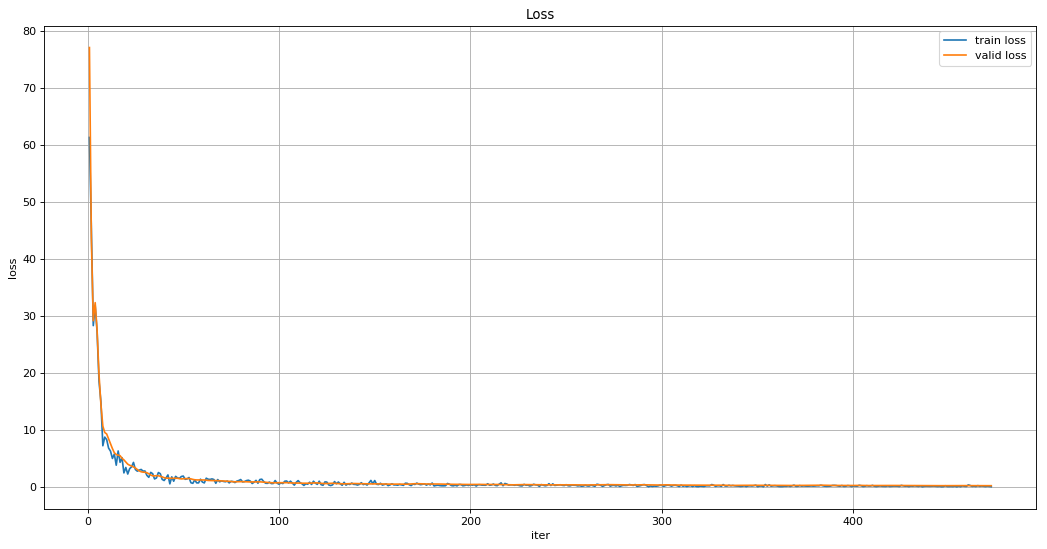

In [37]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

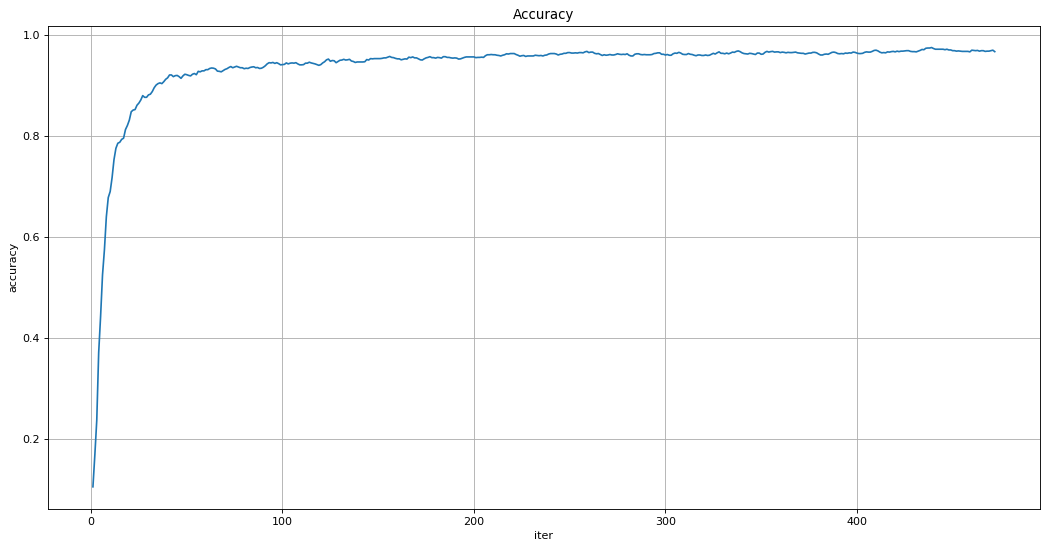

In [38]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()